In [1]:
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '/home/hojat/Desktop/TOUGH2/PyTOUGH-master')

## PyTOUGH specific modules
from mulgrids import *
from t2thermo import *
from t2data import *
from t2incons import *
from os import system
import scipy.io as sio

from pyPCGA import PCGA

In [2]:
def clear_FOFT():
    """To delete previous FOFT qnd MESH files in the directory.
You can delete SAVE, INCON, ... files the same way if you need to do it before running"""
    for file in os.listdir("."):
        if file.startswith("FOFT") or file.startswith("MES"):
            try:
                os.remove(file)
            except Exception.e:  # was a comma, changed to a period
                print(e)         # was print e, changed to print(e)
                
def forward_run():
    """ running the tough2 model"""
    system("mpiexec tough2-mp-eos1.debug")

def read_FOFT():
    """ Function to read all FOFT files in the directory.
    The function returns a pandas dataframe containing measurements"""
    FOFT_files = [filename for filename in os.listdir('.') if filename.startswith("FOFT")]
    columns_name = ['Element','Time', 'Pressure', 'Saturation','Temperature']
    rows = [] 
    for filename in FOFT_files:
        with open(filename, 'rb') as f_input:
            count =0
            for row in f_input:
                if count > 1:
                    a= str(row[0:-1])
                    cols = [col for col in a[2:-1].split(' ') if len(col)]
                    if len(cols)==7:
                        cols[1] = cols[1].ljust(2)
                        cols[1] = cols[1].rjust(3) + cols[2].rjust(2)
                        cols.pop(2)
                        cols.pop(0)
                        rows.append(cols)
                    if len(cols)==6:
                        cols[1] = cols[1].rjust(5)
                        cols.pop(0)
                        rows.append(cols)
                count+=1
    frame = pd.DataFrame(rows, columns=columns_name)
    frame[['Time','Pressure','Saturation','Temperature']] = frame[['Time','Pressure','Saturation','Temperature']].apply(pd.to_numeric)
    return frame

def read_FOFT_old():
    """ Function to read all FOFT files in the directory.
    The function returns a pandas dataframe containing measurements"""
    FOFT_files = [filename for filename in os.listdir('.') if filename.startswith("FOFT")]
    columns = ['FOFT','Element','Time', 'Pressure', 'Saturation','Temperature']
    b=pd.read_csv(FOFT_files[0],names =columns,  sep="\s+", header =None, skiprows=[0,1])
    if len(b.columns) ==6:
        b[1] = b[1].str.rjust(5)
        b = b.drop([0], axis=1)
    elif len(b.columns) ==7:
        b[1] = b[1].str.ljust(2)
        b[2]=b[2].astype(str)
        b[1] = b[1].str.rjust(3) + b[2].str.rjust(2)
        b = b.drop([0,2], axis=1)
    b.columns= ['Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
    for i in range(1, len(FOFT_files)):
        a=pd.read_csv(FOFT_files[i], sep="\s+", header =None, skiprows=[0,1])
        if len(a.columns) ==6:
            a[1] = a[1].str.rjust(5)
            a = a.drop([0], axis=1)
        elif len(a.columns) ==7:
            a[1] = a[1].str.ljust(2)
            a[2] = a[2].astype(str)
            a[1] = a[1].str.rjust(3) + a[2].str.rjust(2)
            a = a.drop([0,2], axis=1)
        a.columns= ['Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
        b=pd.concat([b,a], ignore_index=True)

    return b

def set_measurement_blk_list(dat, x_mid, dx, y_mid, dy, z_mid, dz):
    dat.history_block=[]
    for blk in dat.grid.blocklist[1:]:
        if z_mid-dz/2 < blk.centre[2] < z_mid+dz/2:
            if x_mid-dx/2 < blk.centre[0] < x_mid+dx/2:
                if y_mid-dy/2 < blk.centre[1] < y_mid+dy/2:
                    dat.history_block.append(blk.name)
                    
def set_measurement_blk(dat, x, y, z, nx):
    
    
    dat.history_block = []
    x_obs = np.array(x)
    y_obs = np.array(y)
    z_obs = np.array(z)
    block_list = nx[0]*nx[1]*(z_obs-1)+nx[0]*(y_obs-1)+x_obs
    for blk_number in block_list:
        dat.history_block.append(dat.grid.blocklist[blk_number].name)


def heat_generator(dat, geo, center, L, qmax, L_scale, method = 'Square'):
    
    
    cols =[]
    if method =='Square':
        #for col in geo.columnlist:
        #    if center[0] - L/2 <= col.centre[0] <= center[0] + L/2:
        #        if center[1] - L/2<= col.centre[1]<= center[1] + L/2:
        #            cols.append(col)
        #dxs=np.array([col.centre[0]-center[0] for col in cols])/L_scale
        #dys=np.array([col.centre[1]-center[1] for col in cols])/L_scale
        #print(dxs)
        #print(dys)
        #corlength = 0.5
        #qcol=qmax*np.exp(-0.5*((dxs*dxs+dys*dys)/(corlength*corlength)))
        #print(qcol)
        
        #layer=geo.layerlist[-1] Changing to add the heat in a non-boundary layer
        layer=geo.layerlist[-5]
        # Page 87 from pyTOUGH #####################################
        # adding the generator to the problem
        dat.clear_generators()
        
        dat.add_generator(t2generator(name=' in1', block=' d125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in2', block=' e125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in3', block=' f125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in4', block=' g125', type='COM1', gx=.6, ex=3.E+5))
        
        dat.add_generator(t2generator(name=' ex1', block=' d145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex2', block=' e145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex3', block=' f145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex4', block=' g145', type='COM1', gx=-.6))
        
        #for col,q in zip(cols,qcol):
        #    blkname=geo.block_name(layer.name,col.name)
        #    genname=' q'+col.name
        #    dat.add_generator(t2generator(name=genname, block=blkname, type='HEAT', gx=q*col.area))
        dat.short_output={}
    else:
        raise NotImplementedError

def construct_grid(dx_grid, nx):
    """Constructing a TOUGH2 input geometry file for a 3D rectangular
    model with the domain size of 300*300*20 m^3 and grid size 10*10*2 m^3."""

    # Here we set up a rectangular grid. For other option, refer to pytough examples and tutorials
    dx = [dx_grid[0]]*nx[0]
    dy = [dx_grid[1]]*nx[1]
    dz = [dx_grid[2]]*nx[2]
    # use convention =2 for naming convention. Otherwise it will generate an error when you want to write INFILE
    # for atmos_type, refer to page 124 pyTOUGH tutorial
    geo = mulgrid().rectangular(dx, dy, dz, atmos_type = 0, convention=2) 
    geo.write('geom.dat')      # write the geometry file

    return geo


#def set_rocktype(dat, z_bottom, z_middle, z_top):
    

def read_SAVE():
    data_SAVE= pd.read_csv('SAVE',sep="\s+", header =None, skiprows=[0], error_bad_lines = False)
    data_SAVE = data_SAVE.drop([0,1, len(data_SAVE)-1])
    blk_1 = []
    blk_2 = []
    blk_3 = []
    for i in range(2,len(data_SAVE)+2):
        if i%2 ==0:
            if math.isnan(data_SAVE[2][i]):
                blk_1.append(data_SAVE[1][i])
            else:
                blk_1.append(data_SAVE[2][i])
        else:
            blk_2.append(float(data_SAVE[0][i]))
            blk_3.append(float(data_SAVE[1][i]))
    data_save = {'Saturation': blk_1,
                 'Pressure': blk_2,
                 'Temperature': blk_3}
    
    df = pd.DataFrame.from_dict(data_save)
    
    return df

def plot_FoFT(data_FOFT, Elem, variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400]):
    ###NOTE THAT PLOTFOFT WILL NOT PLOT ANY OF THE LOCATIONS THAT HAVE A BLANK IN THEIR NAME
    x = np.array(data_FOFT[data_FOFT['Element']==Elem]['Time'])
    plt.plot(x,data_FOFT[data_FOFT['Element']==Elem][variable])
    #plt.axis([0, x[-1], ylim[0], ylim[1]])
    plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
    #plt.yticks([])
    plt.show()
    
def plot_SAVE(df, nx, y=0, col = 'Temperature', clim = [0, 100]):
    # old code
    #data_save=np.array(df['Col_1'])
    #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
    #plt.imshow(a[:,:,5].T)
    #plt.colorbar()
    
    #df: output of read_SAVE() function
    # nx: number of grids in the domain in each direction
    # col: can be 'Temperature', 'Pressure', or 'Saturation'
    # clim: determines the range for colorbar
    
    #data_save=np.array(df[col])
    #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
    #plt.imshow(a[:,y,:].T)
    #plt.colorbar()
    #plt.clim(clim[0],clim[1])
    #plt.title(col)
    n = len(dat.grid.blocklist)-1
    elevation_save = np.zeros((n,1))
    for idblock in range(1,n):
        elevation_save[idblock-1] = dat.grid.blocklist[idblock].centre[2]
        
    z = np.reshape(elevation_save,(nx[2],nx[1],nx[0]))
    
    data_save=np.array(df[col])
    
    if col == 'Pressure':
        # Gas pressure converted to m H2O + elevation = hydraulic head in water
        a = np.reshape(data_save*0.00010197,(nx[2],nx[1],nx[0])).T + z.T
        #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T 
        plt.imshow(a[:,y,:].T)
        #plt.colorbar()
        plt.clim(clim[0],clim[1])
        plt.title('Hydraulic head (m)')
    else:
        a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
        plt.imshow(a[:,y,:].T)
        #plt.colorbar()
        plt.clim(clim[0],clim[1])
        plt.title(col)

def modify_infile():
    f = open("INFILE", "r")
    contents = f.readlines()
    f.close()
    contents.insert(5, 'SEED\n')
    f = open("INFILE", "w")
    contents = "".join(contents)
    f.write(contents)
    f.close()
    
    return

def observation_model():
    
    obs_type = 'Temperature'
    #obs_type = 'Pressure'
    #measured_data = read_FOFT()
    measured_data = read_SAVE()
    obs = measured_data[obs_type]
    m_s = np.array(obs)
    meas = m_s[0::20]
    return meas
    
    
def forward_model(s, parallelization, ncores=None):
    print('shape of s is:')
    print(s.shape)
    print('The first 10 elements of first three columns are:')
    print(s[0:10,0:3])
    measured_data = read_FOFT()
    obs1=measured_data['Temperature']
    b=np.array(obs1)
    blk = dat.grid.blocklist[1:]
    if parallelization:
        obs = np.zeros((n_obs,s.shape[1]))
        for j in range(s.shape[1]):
            print(s.shape)
            s_in = np.exp(s[:,j])
            for blk, pmx in zip(dat.grid.blocklist[1:], s_in):
                blk.pmx = pmx
            dat.write('INFILE')
            modify_infile()
            clear_FOFT()
            system("mpiexec tough2-mp-eos1.debug")
            #measured_data = read_FOFT()
            #pressure=measured_data['Temperature']
            measurements = observation_model()
            b=np.array(measurements)
            obs[:,j] = b.reshape(-1,)
        print('The first 10 elements of first three columns of outputs are:')
        print(s[0:10,0:3])
        return obs
            
    for i in range(len(s)):
        blk[i].pmx = float(s[i])
    dat.write('INFILE')
    modify_infile()
    clear_FOFT()
    system("mpiexec tough2-mp-eos1.debug")
    #measured_data = read_FOFT()
    #pressure=measured_data['Temperature']
    measurements = observation_model()
    obs=np.array(measurements)
    obs = obs.reshape(-1,1)
    return obs

## From Harry's code
from IPython.core.debugger import Tracer; debug_here = Tracer()

def DistanceVector(x, y, theta):
    dim = x.shape[1]
    DM = np.zeros(x.shape[0])

    if dim == 1:
        DM = (x[:] - y) ** 2. / theta ** 2.
    else:
        for i in np.arange(dim):
            DM += (x[:, i] - y[i]) ** 2. / theta[i] ** 2.

    DM = np.sqrt(DM)
    return DM


def CreateRow(xmin, xmax, N, kernel, theta):
    """
    Create row column of covariance matrix
    """
    dim = N.size

    if dim == 1:
        x = np.linspace(xmin[0], xmax[0], N[0])
        x = x.reshape(-1,1) # make it 2D for consistency
        R = DistanceVector(x, x[0], theta)
    elif dim == 2:
        x1 = np.linspace(xmin[0], xmax[0], N[0])
        x2 = np.linspace(xmin[1], xmax[1], N[1])

        xx, yy = np.meshgrid(x1, x2, indexing='ij')

        x = np.vstack((np.ravel(xx, order='F'), np.ravel(yy, order='F'))).transpose()
        R = DistanceVector(x, x[0, :].transpose(), theta)

    elif dim == 3:
        x1 = np.linspace(xmin[0], xmax[0], N[0])
        x2 = np.linspace(xmin[1], xmax[1], N[1])
        x3 = np.linspace(xmin[2], xmax[2], N[2])

        #xx, yy, zz = np.meshgrid(x1, x2, x3, indexing='ij')
        xx, yy, zz = np.meshgrid(x1, x2, x3, indexing='ij')

        x = np.vstack((np.ravel(xx, order='F'), np.ravel(yy, order='F'), np.ravel(zz, order='F'))).transpose()
        R = DistanceVector(x, x[0, :].transpose(), theta)

    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    row = kernel(R)

    return row, x


def ToeplitzProduct(x, row, N):
    ''' Toeplitz matrix times x
    :param x: x for Qx
    :param row: from CreateRow
    :param N: size in each dimension ex) N = [2,3,4]
    :return: Qx
    '''
    dim = N.size

    if dim == 1:
        circ = np.concatenate((row, row[-2:0:-1])).reshape(-1)
        padded = np.concatenate((x, np.zeros(N[0] - 2)))
        result = np.fft.ifft(np.fft.fft(circ) * np.fft.fft(padded))
        result = np.real(result[0:N[0]])

    elif dim == 2:
        circ = np.reshape(row, (N[0], N[1]), order='F')
        circ = np.concatenate((circ, circ[:, -2:0:-1]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :]), axis=0)

        n = np.shape(circ)
        padded = np.reshape(x, (N[0], N[1]), order='F')

        result = np.fft.ifft2(np.fft.fft2(circ) * np.fft.fft2(padded, n))
        result = np.real(result[0:N[0], 0:N[1]])
        result = np.reshape(result, -1, order='F')

    elif dim == 3:
        circ = np.reshape(row, (N[0], N[1], N[2]), order='F')
        circ = np.concatenate((circ, circ[:, :, -2:0:-1]), axis=2)
        circ = np.concatenate((circ, circ[:, -2:0:-1, :]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :, :]), axis=0)

        n = np.shape(circ)
        padded = np.reshape(x, N, order='F')

        result = np.fft.ifftn(np.fft.fftn(circ) * np.fft.fftn(padded, n))
        result = np.real(result[0:N[0], 0:N[1], 0:N[2]])
        result = np.reshape(result, -1, order='F')
    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    return result


def Realizations(row, N):
    dim = N.size
    if dim == 1:
        circ = np.concatenate((row, row[-2:0:-1]))
        n = circ.shape

        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)
        res = np.fft.ifft(np.sqrt(np.fft.fft(circ)) * eps) * np.sqrt(n)

        r1 = np.real(res[0:N[0]])
        r2 = np.imag(res[0:N[0]])

    elif dim == 2:
        circ = np.reshape(row, (N[0], N[1]), order='F')
        circ = np.concatenate((circ, circ[:, -2:0:-1]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :]), axis=0)

        n = np.shape(circ)
        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)

        res = np.fft.ifft2(np.sqrt(np.fft.fft2(circ)) * eps) * np.sqrt(n[0] * n[1])
        res = res[0:N[0], 0:N[1]]
        res = np.reshape(res, -1, order='F')

        r1 = np.real(res)
        r2 = np.imag(res)

    elif dim == 3:
        circ = np.reshape(row, (N[0], N[1], N[2]), order='F')
        circ = np.concatenate((circ, circ[:, :, -2:0:-1]), axis=2)
        circ = np.concatenate((circ, circ[:, -2:0:-1, :]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :, :]), axis=0)

        n = np.shape(circ)
        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)

        res = np.fft.ifftn(np.sqrt(np.fft.fftn(circ)) * eps) * np.sqrt(n[0] * n[1] * n[2])
        res = res[0:N[0], 0:N[1], 0:N[2]]
        res = np.reshape(res, -1, order='F')

        r1 = np.real(res)
        r2 = np.imag(res)
    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    return r1, r2, eps


/home/hojat/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:294: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


In [3]:
# Create TOUGH2 input data file:
dat = t2data()
dat.title = '3D synthetic Ex1'

dx = [10., 10., 2.]   # grid size
nx = [30, 10, 10]     # number of grids in each dimension. Don't use large grid because of pytough naming convention
geo = construct_grid(dx, nx)
dat.grid = t2grid().fromgeo(geo)


33.11271807442939
15.784224964766244


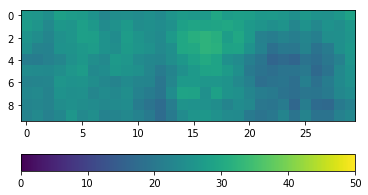

In [4]:
alpha = 100
def kernel(R):
        return alpha * np.exp(-R)
prior_std = 1
prior_cov_scale = np.array([300., 300., 10])

dim = 3
np.random.seed(101)
N = np.array(nx)
dX = np.array(dx)
x_max = N*dX
x_min = np.zeros(dim)
theta = np.array([1000,1000,1000])
row, pts = CreateRow(x_min, x_max, N, kernel,theta)
r1, r2, ep = Realizations(row, N)
realization = np.sqrt(r1**2+r2**2)
realization1 = realization.reshape(N[2],N[1],N[0])
plt.imshow(realization1[6,:,:] )
plt.colorbar(orientation='horizontal')
plt.clim(0,50)
print(np.max(realization))
print(np.min(realization))
s_t = realization1

def kernel(r): return (prior_std**2)*np.exp(-r**2)

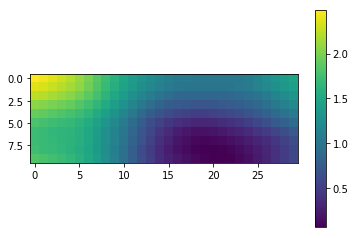

In [141]:
data_pmx = sio.loadmat('true_pmx.mat')
s_true = data_pmx['s_true']
s_true = s_true-np.min(s_true)
s_true = s_true/2
pts = data_pmx['pts']
#s_t = np.log(s_t)
plt.imshow(s_true[:,6,:].T)
plt.colorbar()
s_true = s_true.reshape(-1,1)
realization = s_true

In [94]:
# simulation parameters:
# Table 4.9 page 78 pytough tutorial and Appendix E of TOUGH2 tutorial
# data.parameter is a dictionary
# each parameter can be called as dat.parameter['parameter name']
dat.parameter.update(
    {'max_timesteps': 9000,                 # maximum number of time steps
     'tstop': 0.32342126E+07,                   # stop time
     #'tstop': 100000,                   # stop time
     'const_timestep': 6,                   # time step length
     'max_timestep':86400,                   # maximum time step size
     'absolute_error': 1,                   # absolute convergence tolerance
     'relative_error': 5.e-6,               # relative convergence tolerance
     'print_interval': 9000,                # time step interval for printing
     'timestep_reduction': 3.,              # time step reduction factor
     'gravity': 9.81,                       # gravitational acceleration
     'default_incons': [100.e4, 10]})      # default initial conditions
    # Pressure in Pa, 100 m water = 10.e5 Pa water, 10 is the temperature in Celcius
dat.start = True

In [95]:

# Table 4.9 page 78 pytough tutorial and Appendix E of TOUGH2 tutorial
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.396.8810&rep=rep1&type=pdf
# Set MOPs: PARAM option in INFILE
dat.parameter['option'][1] = 1
dat.parameter['option'][5] = 3
dat.parameter['option'][7] = 1
dat.parameter['option'][11] = 2
dat.parameter['option'][12] = 2
dat.parameter['option'][15] = 1
dat.parameter['option'][16] = 4
dat.parameter['option'][20] = 0
dat.parameter['option'][21] = 1


# Set relative permeability (Corey) and capillarity functions:
# Table 4.10, page 79 PYTOUGH
dat.relative_permeability = {'type': 7, 'parameters': [0.95, 0.5, 1., 0.25, 0.]}
dat.capillarity = {'type': 7, 'parameters': [0.8, 0.32, 1.e-4, 1.e7, 0.999]}


# rocktype object, Table 3.3, page 67 PyTOUGH
r1 = rocktype('dfalt', permeability = [0.e-13]*3,density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
r2 = rocktype('HOMO1', permeability = [9.e-13, 3.e-14, 3.e-14],density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
#r4 = rocktype('HOMO2', permeability = [9.e-15, 3.e-15, 3.e-15],density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
r3 = rocktype('OUTB1', permeability = [1.e-13]*3,density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 20000,)

dat.grid.add_rocktype(r2)
dat.grid.add_rocktype(r3)
#dat.grid.add_rocktype(r4)

#dat.grid.add_rocktype(r3)
dat.multi.update({'num_components': 1, 'num_equations':2, 'num_phases':2, 'num_secondary_parameters':6})


print(dat.multi)
dat.grid.rocktype
dat.grid.rocktype
dat.grid.check
r3.permeability

{'num_components': 1, 'num_phases': 2, 'num_secondary_parameters': 6, 'num_equations': 2}


array([1.e-13, 1.e-13, 1.e-13])

In [96]:
# SOLVR Table 4.11 page 79 PyTough
dat.solver.update({'type': 5, 'z_precond':1,'o_precond': 0, 'relative_max_iterations':.8,'closure':1.e-7 })
# TIMES table 4.8
dat.output_times.update({'num_times_specified':2, 'time': [0.8640E+04, 0.32342126E+08]})
print(dat.output_times['time'][1]/86400)
# prints output times in days

dat.grid.blocklist[1000].centre

374.330162037


array([95., 35., -7.])

In [126]:
# rocktypes:
# Setting rocktype based on the block's 'z' coordinate
z_bottom = -17
z_top = -2

# assign all non boundary elements to r2
for blk in dat.grid.blocklist[1:]: 
    if z_bottom < blk.centre[2] < z_top:
        blk.rocktype=r2
    else: blk.rocktype=r3
   
lense = 0

if lense==1:
    # within homeogeneous domain, assign a lense that is in the way of the injection
    lense_bottom_z = -14
    lense_top_z = -8
    lense_start_x = 65
    lense_end_x = 115
    for blk in dat.grid.blocklist[1:]:
        if lense_bottom_z < blk.centre[2] < lense_top_z:
            if lense_start_x < blk.centre[0] < lense_end_x:
                blk.rocktype=r4
    
dat.grid.clean_rocktypes()


for blk, pmx in zip(dat.grid.blocklist[1:], np.exp(s_true)):
    #blk.pmx = 1
    blk.pmx = pmx
    #print(pmxb)

print(dat.grid)
print(r2)

3 rock types; 3001 blocks; 8600 connections
HOMO1


In [127]:
# setting the blocks for FOFT
# this section needs to be modified. FOFT blocks can be given by the coordinate of the block, or by the block name
# currently, it accepts the cell number in each direction
# for example the first cell here is located in grid (2,2) in 5th layer
#x_obs = [7,15,20]#[2,4,14,16]
#y_obs = [14,14,14]#[2,4,14,16]
#z_obs = [6,6,6]

# from function definition above 
# set_measurement_blk(dat, x, y, z, nx):
#set_measurement_blk(dat, x_obs, y_obs, z_obs, nx)

## you can add duplicates of this block with different xyz locations
x_mid = 150
y_mid = 50
z_mid = -10
dx = 80
dy = 60
dz = 8
dat.history_block=[]
set_measurement_blk_list(dat, x_mid, dx, y_mid, dy, z_mid, dz)

#print(dat.history_block)
#print(nx)


In [128]:
# just checking the name of measurement blocks
# f124 coordinates are 35,45,10  and it is the 2nd observationn point at 4,4,5 element :1

len(dat.history_block)

# adding generators to the model

center = [150, 150] # [x,y] position of the center
L = 40     # length of one side of square
qmax = 15000
L_scale = 300


heat_generator(dat, geo, center, L, qmax, L_scale, method = 'Square')
# just checking the generator blocks


# Write data file

dat.write('INFILE')
modify_infile()

clear_FOFT()


In [129]:
# running tough2_mp
forward_run()

In [63]:
measured_data = read_FOFT()


In [130]:
#measured_data = read_FOFT()
measurements = observation_model()
obs = np.array(measurements)
#obs = obs+.1*np.random.randn(obs.shape[0],1)  # ADDING NOISE TO MEASUREMENTS
n_obs = len(obs)

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



In [131]:
n_obs

150

In [132]:
np.linalg.norm(obs-obs1)

0.0

In [133]:
#s_true = realization #'post_cov':"diag",

In [134]:
params = {'R':(.01)**2, 'n_pc':20,
          'maxiter':5, 'restol':0.01,
          'matvec':'FFT','xmin':x_min, 'xmax':x_max, 'N':N,
          'prior_std':prior_std,'prior_cov_scale':prior_cov_scale,
          'kernel':kernel, 
          'precond':True, 'LM': True,
          'parallel':True, 'linesearch' : True,'precision':0.00001,
          'forward_model_verbose': True, 'verbose': True,
          'iter_save': True}

In [135]:
s_init = np.mean(s_true)*np.ones((len(s_true),1))


In [136]:
prob = PCGA(forward_model, s_init = s_init, pts = pts, params = params, s_true = s_true, obs = obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 3000
   Number of observations                           : 150
   Number of principal components (n_pc)            : 20
   Prior model                                      : def kernel(r): return (prior_std**2)*np.exp(-r**2)

   Prior variance                                   : 1.000000e+00
   Prior scale (correlation) parameter              : [300. 300.  10.]
   Posterior cov computation                        : False
   Number of CPU cores (n_core)                     : 12
   Maximum GN iterations                            : 5
   machine precision (delta = sqrt(precision))      : 1.000000e-05
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : True
   LM solution range constraints (LM_smin, LM_smax) : None, None
   Line sea

In [137]:
#s_hat, simul_obs, post_diagv, iter_best = prob.Run()
s_hat, simul_obs, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 3000) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 20 is 0 sec
- 1st eigv : 1543.48, 20-th eigv : 0.790084, ratio: 0.000511884
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
shape of s is:
(3000, 1)
The first 10 elements of first three columns are:
[[1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]
 [1.12784629]]


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 0.223155, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 22.3155
***** Iteration 1 ******
shape of s is:
(3000, 22)
The first 10 elements of first three columns are:
[[1.13141285 1.12995385 1.13138944]
 [1.13141285 1.13001406 1.13149066]
 [1.13141285 1.13007148 1.1315872 ]
 [1.13141285 1.13012583 1.13167856]
 [1.13141285 1.13017679 1.13176425]
 [1.13141285 1.1302241  1.13184378]
 [1.13141285 1.13026749 1.13191672]
 [1.13141285 1.13030672 1.13198267]
 [1.13141285 1.13034155 1.13204123]
 [1.13141285 1.1303718  1.13209208]]
(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.13141285 1.12995385 1.13138944]
 [1.13141285 1.13001406 1.13149066]
 [1.13141285 1.13007148 1.1315872 ]
 [1.13141285 1.13012583 1.13167856]
 [1.13141285 1.13017679 1.13176425]
 [1.13141285 1.1302241  1.13184378]
 [1.13141285 1.13026749 1.13191672]
 [1.13141285 1.13030672 1.13198267]
 [1.13141285 1.13034155 1.13204123]
 [1.13141285 1.1303718  1.13209208]]
computed Jacobian-Matrix products in 123.482045 secs
eig. val. of generalized data covariance : 0.002391 secs (3.45e-04, 3.45e-04, 1.43e+00)
time for data covarance construction : 0.034013 sec 
eig. val. of data covariance (2.15e+06, 1.05e-03, 2.15e+06)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 2
0 - min(s): -6.71559, max(s) :5.289
-- Number of iterations for gmres 2
1 - min(s): -4.97453, max(s) :3.63405
-- Number of iterations for gmres 2
2 - min(s): -3.68704, max(s) :2.42447
-- Number of iterations for gmres 1
3 -

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[-1.19451039  0.19231962  1.25429634]
 [-1.45760111 -0.04538232  1.03825882]
 [-1.7046689  -0.2742091   0.82505837]
 [-1.93377122 -0.49232819  0.61638488]
 [-2.14317233 -0.69802921  0.41387378]
 [-2.33136823 -0.88974772  0.21908406]
 [-2.49710779 -1.06608668  0.03347756]
 [-2.6394096  -1.22583504 -0.1416001 ]
 [-2.757574   -1.36798318 -0.30493663]
 [-2.85119034 -1.49173485 -0.45546785]]
LM solution evaluted
12 objective value evaluations
0-th solution obj 1.893146e+05 (alpha 1.000000)
1-th solution obj 4.480546e+04 (alpha 1.873817)
3-th solution obj 4.236617e+04 (alpha 6.579332)
4-th solution obj 3.687453e+04 (alpha 12.328467)
5-th solution obj 3.018678e+04 (alpha 23.101297)
6-th solution obj 2.258788e+04 (alpha 43.287613)
7-th solution obj 1.533326e+04 (alpha 81.113083)
8-th solution obj 9.863227e+03 (alpha 151.991108)
9-th solution obj 6.501155e+03 (alpha 284.803587)
10-th solution obj 4.613796e+03 (alpha 533.669923)
11-th

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[2.17890867 2.17775222 2.17904932]
 [2.11915316 2.11803965 2.11937381]
 [2.05686146 2.05578891 2.05715841]
 [1.99248133 1.99144754 1.99285048]
 [1.92648052 1.92548307 1.92691739]
 [1.85934115 1.85837745 1.85984088]
 [1.79155389 1.79062113 1.79211127]
 [1.72361194 1.72270715 1.72422143]
 [1.6560051  1.65512517 1.65666088]
 [1.5892139  1.58835553 1.58990987]]
computed Jacobian-Matrix products in 118.340650 secs
eig. val. of generalized data covariance : 0.002652 secs (4.07e-04, 4.07e-04, 2.10e+00)
time for data covarance construction : 0.004268 sec 
eig. val. of data covariance (5.01e+04, 7.98e-04, 5.01e+04)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 1
0 - min(s): -2.07133, max(s) :1.07202
-- Number of iterations for gmres 1
1 - min(s): -1.92352, max(s) :1.05597
-- Number of iterations for gmres 1
2 - min(s): -1.7966, max(s) :1.10367
-- Number of iterations for gmres 1
3 

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[0.98049295 1.0177856  1.03575511]
 [0.93484436 0.97285272 0.9910803 ]
 [0.88903385 0.92652279 0.9442313 ]
 [0.84365313 0.87929785 0.89563848]
 [0.79926109 0.83166722 0.84573372]
 [0.75637416 0.78409968 0.7949441 ]
 [0.71545768 0.73703626 0.74368582]
 [0.67691816 0.69088352 0.69235842]
 [0.64109678 0.64600767 0.64133941]
 [0.60826423 0.60272947 0.59097945]]
LM solution evaluted
12 objective value evaluations
0-th solution obj 8.052589e+02 (alpha 1.000000)
1-th solution obj 5.181941e+02 (alpha 1.873817)
2-th solution obj 3.696329e+02 (alpha 3.511192)
5-th solution obj 3.377462e+02 (alpha 23.101297)
- Geostat. inversion at iteration 2 is 187 sec
== iteration 2 summary ==
= objective function is 3.377462e+02, relative L2-norm diff btw sol 1 and sol 2 is 1.15763
= L2-norm error (w.r.t truth) is 1.08872, obs. RMSE is 0.0210532, obs. normalized RMSE is 2.10532
- save results in text at iteration 2
***** Iteration 3 ******
shape of

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.38166606 1.38250595 1.38580591]
 [1.339242   1.34004863 1.34344286]
 [1.29442833 1.29520322 1.29868737]
 [1.24754896 1.24829382 1.25186306]
 [1.19894176 1.19965846 1.2033075 ]
 [1.14895436 1.14964492 1.15336803]
 [1.09793985 1.09860643 1.10239749]
 [1.04625246 1.04689737 1.05074983]
 [0.99424332 0.99486899 0.998776  ]
 [0.9422564  0.94286535 0.94681972]]
computed Jacobian-Matrix products in 143.186407 secs
eig. val. of generalized data covariance : 0.002412 secs (4.68e-04, 4.68e-04, 2.08e+00)
time for data covarance construction : 0.004035 sec 
eig. val. of data covariance (4.92e+04, 1.32e-03, 4.92e+04)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 1
0 - min(s): -0.97729, max(s) :1.94233
-- Number of iterations for gmres 1
1 - min(s): -0.909786, max(s) :1.97439
-- Number of iterations for gmres 1
2 - min(s): -0.836121, max(s) :2.00134
-- Number of iterations for gmres 1

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.21011239 1.35323275 1.51200185]
 [1.15999124 1.30154669 1.45943353]
 [1.11187425 1.25158134 1.40816674]
 [1.0662244  1.20386362 1.35876317]
 [1.02346606 1.15888745 1.31175739]
 [0.98397834 1.11710606 1.26764847]
 [0.94808917 1.07892485 1.22689226]
 [0.91607039 1.0446952  1.18989434]
 [0.88813389 1.01470916 1.15700385]
 [0.86442875 0.9891952  1.12850828]]
LM solution evaluted
12 objective value evaluations
0-th solution obj 1.808116e+03 (alpha 1.000000)
1-th solution obj 1.452452e+03 (alpha 1.873817)
2-th solution obj 1.252597e+03 (alpha 3.511192)
3-th solution obj 1.165198e+03 (alpha 6.579332)
4-th solution obj 1.148575e+03 (alpha 12.328467)
- Geostat. inversion at iteration 3 is 210 sec
perform simple linesearch due to no progress in obj value
evaluate linesearch solutions
shape of s is:
(3000, 12)
The first 10 elements of first three columns are:
[[1.87075499 1.82244909 1.77414319]
 [1.81722329 1.77001898 1.72281466]
 [

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.87075499 1.82244909 1.77414319]
 [1.81722329 1.77001898 1.72281466]
 [1.7643441  1.71793967 1.67153524]
 [1.71271596 1.66678248 1.620849  ]
 [1.66291736 1.61710204 1.57128671]
 [1.6154978  1.56942782 1.52335783]
 [1.57096928 1.52425606 1.47754284]
 [1.5297984  1.48204222 1.43428604]
 [1.49239921 1.44319411 1.39398901]
 [1.45912695 1.40806585 1.35700475]]
0-th solution obj 1.413791e+03 (delta -0.100000)
1-th solution obj 1.125208e+03 (delta 0.009091)
2-th solution obj 8.762223e+02 (delta 0.118182)
3-th solution obj 6.662485e+02 (delta 0.227273)
4-th solution obj 4.970732e+02 (delta 0.336364)
5-th solution obj 3.650364e+02 (delta 0.445455)
6-th solution obj 2.744146e+02 (delta 0.554545)
7-th solution obj 2.243127e+02 (delta 0.663636)
8-th solution obj 2.152231e+02 (delta 0.772727)
== iteration 3 summary ==
= objective function is 2.152231e+02, relative L2-norm diff btw sol 2 and sol 3 is 0.311809
= L2-norm error (w.r.t trut

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.48616632 1.48325292 1.48639733]
 [1.4414473  1.43850375 1.441738  ]
 [1.3949672  1.39199491 1.39531484]
 [1.34710667 1.34410718 1.34750819]
 [1.29825331 1.29522832 1.29870536]
 [1.24879646 1.24574778 1.24929541]
 [1.19912203 1.19605164 1.199664  ]
 [1.14960747 1.14651745 1.15018833]
 [1.10061692 1.09750946 1.10123232]
 [1.05249667 1.04937407 1.05314205]]
computed Jacobian-Matrix products in 117.734132 secs
eig. val. of generalized data covariance : 0.002410 secs (5.55e-04, 5.55e-04, 1.81e+00)
time for data covarance construction : 0.004141 sec 
eig. val. of data covariance (5.42e+04, 1.49e-03, 5.42e+04)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 1
0 - min(s): -0.528949, max(s) :2.34992
-- Number of iterations for gmres 1
1 - min(s): -0.643687, max(s) :2.30337
-- Number of iterations for gmres 1
2 - min(s): -0.783093, max(s) :2.24021
-- Number of iterations for gmres 

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[2.34991749 2.30336982 2.24021169]
 [2.30983193 2.26624773 2.20479593]
 [2.26549258 2.22466197 2.1648307 ]
 [2.21723669 2.17895111 2.12065524]
 [2.16541086 2.12946952 2.07262849]
 [2.11036608 2.07658223 2.02112399]
 [2.052453   2.02066005 1.96652476]
 [1.99201749 1.96207469 1.90921826]
 [1.92939663 1.90119421 1.84959151]
 [1.86491517 1.83837884 1.78802645]]
LM solution evaluted
12 objective value evaluations
0-th solution obj 9.894368e+02 (alpha 1.000000)
2-th solution obj 9.870576e+02 (alpha 3.511192)
3-th solution obj 9.401570e+02 (alpha 6.579332)
4-th solution obj 9.086720e+02 (alpha 12.328467)
- Geostat. inversion at iteration 4 is 190 sec
perform simple linesearch due to no progress in obj value
evaluate linesearch solutions
shape of s is:
(3000, 12)
The first 10 elements of first three columns are:
[[2.12122703 2.05806148 1.99489594]
 [2.0877189  2.02344153 1.95916416]
 [2.04942376 1.98433466 1.91924556]
 [2.00667667 1

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[2.12122703 2.05806148 1.99489594]
 [2.0877189  2.02344153 1.95916416]
 [2.04942376 1.98433466 1.91924556]
 [2.00667667 1.94108045 1.87548423]
 [1.95983739 1.89404143 1.82824547]
 [1.90928539 1.84359804 1.77791069]
 [1.85541461 1.79014342 1.72487224]
 [1.79862825 1.73407824 1.66952822]
 [1.73933361 1.67580549 1.61227737]
 [1.67793703 1.61572557 1.55351411]]
0-th solution obj 1.094010e+03 (delta -0.100000)
1-th solution obj 8.867575e+02 (delta 0.009091)
2-th solution obj 7.172494e+02 (delta 0.118182)
3-th solution obj 5.651693e+02 (delta 0.227273)
4-th solution obj 4.400027e+02 (delta 0.336364)
5-th solution obj 3.368519e+02 (delta 0.445455)
6-th solution obj 2.608421e+02 (delta 0.554545)
7-th solution obj 2.097368e+02 (delta 0.663636)
8-th solution obj 1.856879e+02 (delta 0.772727)
== iteration 4 summary ==
= objective function is 1.856879e+02, relative L2-norm diff btw sol 3 and sol 4 is 0.128371
= L2-norm error (w.r.t trut

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 22)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[1.61782639 1.61698704 1.61807123]
 [1.57542367 1.5746153  1.57573045]
 [1.53063467 1.52985585 1.53100055]
 [1.48383064 1.48307978 1.48425243]
 [1.43539342 1.43466877 1.43586765]
 [1.38571029 1.38500999 1.3862332 ]
 [1.33516885 1.33449087 1.3357364 ]
 [1.28415185 1.28349406 1.28475977]
 [1.23303236 1.23239249 1.23367612]
 [1.18216906 1.18154475 1.18284394]]
computed Jacobian-Matrix products in 117.081125 secs
eig. val. of generalized data covariance : 0.002377 secs (5.91e-04, 5.91e-04, 2.02e+00)
time for data covarance construction : 0.004084 sec 
eig. val. of data covariance (5.50e+04, 9.62e-04, 5.50e+04)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 1
0 - min(s): -0.993138, max(s) :2.66277
-- Number of iterations for gmres 1
1 - min(s): -1.0565, max(s) :2.66532
-- Number of iterations for gmres 1
2 - min(s): -1.05368, max(s) :2.57289
-- Number of iterations for gmres 1
3

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[2.65278287 2.66531941 2.57288567]
 [2.59421637 2.60876125 2.51810753]
 [2.52916279 2.54521327 2.4562768 ]
 [2.45768425 2.4747274  2.38746021]
 [2.37986573 2.3973881  2.3117622 ]
 [2.295816   2.31331344 2.22932581]
 [2.2056688  2.22265632 2.1403334 ]
 [2.10958425 2.12560565 2.04500727]
 [2.00775042 2.02238741 1.94361016]
 [1.90038497 1.9132658  1.83644545]]
LM solution evaluted
12 objective value evaluations
0-th solution obj 1.100600e+03 (alpha 1.000000)
1-th solution obj 8.575960e+02 (alpha 1.873817)
2-th solution obj 6.487637e+02 (alpha 3.511192)
3-th solution obj 4.582430e+02 (alpha 6.579332)
4-th solution obj 3.005466e+02 (alpha 12.328467)
- Geostat. inversion at iteration 5 is 182 sec
perform simple linesearch due to no progress in obj value
evaluate linesearch solutions
shape of s is:
(3000, 12)
The first 10 elements of first three columns are:
[[2.0297639  1.98871981 1.94767572]
 [1.97988931 1.93958623 1.89928316]
 [

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



(3000, 12)


Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



The first 10 elements of first three columns of outputs are:
[[2.0297639  1.98871981 1.94767572]
 [1.97988931 1.93958623 1.89928316]
 [1.92367398 1.88450409 1.8453342 ]
 [1.86125087 1.82362999 1.7860091 ]
 [1.79279142 1.7571562  1.72152099]
 [1.71850496 1.68530975 1.65211454]
 [1.6386381  1.6083512  1.57806429]
 [1.55347371 1.52657332 1.49967293]
 [1.46332974 1.44029955 1.41726936]
 [1.36855784 1.34988222 1.3312066 ]]
0-th solution obj 3.702186e+02 (delta -0.100000)
1-th solution obj 2.938264e+02 (delta 0.009091)
2-th solution obj 2.190310e+02 (delta 0.118182)
3-th solution obj 1.637824e+02 (delta 0.227273)
4-th solution obj 1.331646e+02 (delta 0.336364)
5-th solution obj 1.089753e+02 (delta 0.445455)
6-th solution obj 9.921535e+01 (delta 0.554545)
== iteration 5 summary ==
= objective function is 9.921535e+01, relative L2-norm diff btw sol 4 and sol 5 is 0.249531
= L2-norm error (w.r.t truth) is 0.886212, obs. RMSE is 0.0110962, obs. normalized RMSE is 1.10962
- save results in text a

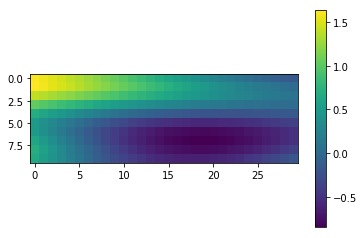

In [138]:
pred = s_hat.reshape(N[2],N[1],N[0])
plt.imshow(pred[:,:,:])
plt.colorbar()

In [139]:
np.max(pred[:,6,:])

1.6409453898613118

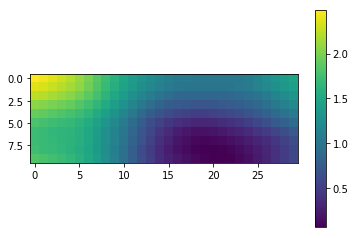

In [140]:
tr_val = s_true.reshape(N[0],N[1],N[2])
plt.imshow(tr_val[:,6,:].T)
plt.colorbar()

In [ ]:
## The following cells are for visualization purpose. You can run them after the first run of forward model.

Skipping line 6005: expected 3 fields, saw 5
Skipping line 6006: expected 3 fields, saw 10



Text(0,0.5,'z(m)')

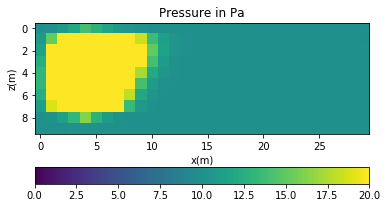

In [104]:
data_save = read_SAVE()

#data_save, 'y' variable here sets which y cross=section you want to plot
plot_SAVE(data_save, nx, y=4, col = 'Temperature', clim = [0, 20])
#data_save=np.array(data_save['Temperature'])
#a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
#plt.imshow(a[:,:,5].T)
plt.colorbar(orientation='horizontal')
plt.title('Pressure in Pa')
plt.xlabel('x(m)')
plt.ylabel('z(m)')


In [ ]:
print(dat.history_block[2])
plot_FoFT(measured_data, dat.history_block[2], variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400*347]) # ylim sets the range fo

In [ ]:
print(dat.history_block[0])
plot_FoFT(measured_data, dat.history_block[0], variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400*347]) # ylim sets the range fo


In [ ]:
print(dat.history_block[1])
plot_FoFT(measured_data, dat.history_block[1], variable = 'Temperature', ylim = [0, 20], xlim = [0, 86400*347]) # ylim sets the range fo


In [ ]:
## Here you are printing the same 
##Elem = dat.history_block[1]
##print(dat.history_block[:])
#for Elm in dat.history_block:
#    print(Elm)
#    plot_FoFT(measured_data, Elm, variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400]) # ylim sets the range for y axis

In [ ]:
data_save_T=np.array(data_save['Temperature']) # you should give the whole data frame as input to plot_SAVE function
data_save_T                                    # so you don't need to read the Temperature column here. I renamed the variable here

In [ ]:
dat.grid.blocklist[1].centre[2]

In [ ]:
plot_SAVE(data_save, nx, y=14, col = 'Temperature', clim = [0, 60])
plt.title('Temperature in C')
plt.xlabel('x(m)')
plt.ylabel('z(m)')
plt.colorbar(orientation='horizontal')